# Altair 30s

In [1]:
import numpy as np
import os
from astropy.io import fits
from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from IPython.display import Image
# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist
from IPython.display import Image
import glob

from PIL import Image
import numpy as np
import pylab as pl
pl.style.use('dark_background')

from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

In [2]:
altair_30s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\altair_30s002.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_30s00*.FIT")],
                        axis=0)
             )


In [3]:
alt_array = np.array(altair_30s_image_data)
alt_array = alt_array - np.median(altair_30s_image_data)

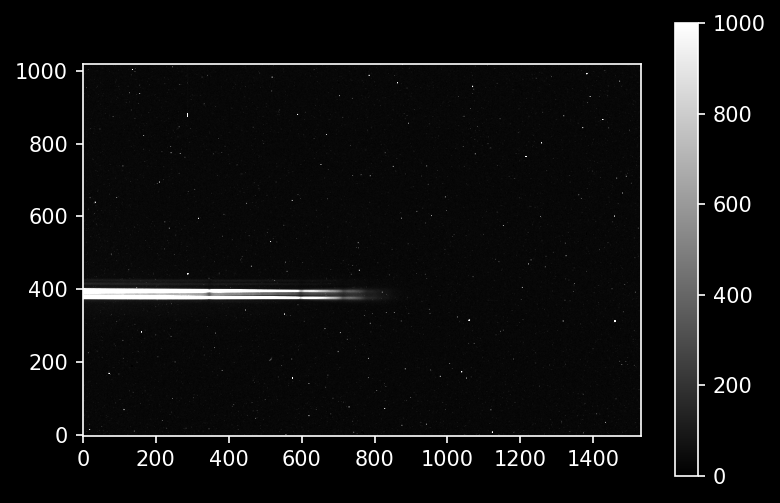

In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.dpi'] = 150
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(altair_30s_image_data, cmap='gray', vmax=0, vmin=1000)
pl.colorbar()

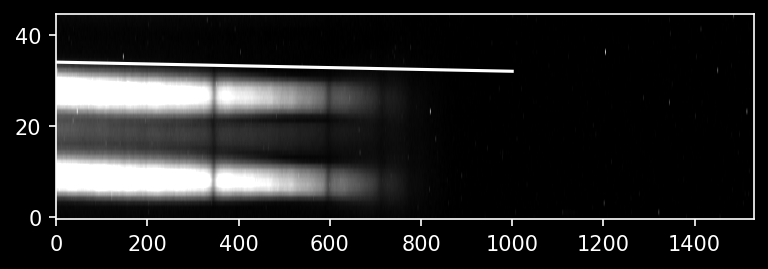

In [5]:
dy = -2
dx = 1000
slope = dy/dx

ystart = 370
yend = 415

pl.imshow(alt_array[ystart:yend,:], cmap='gray', vmax=3000, vmin=0)
pl.plot([0,1000], 34 + np.array([0,1000]) * slope, color='w')
pl.gca().set_aspect(10)

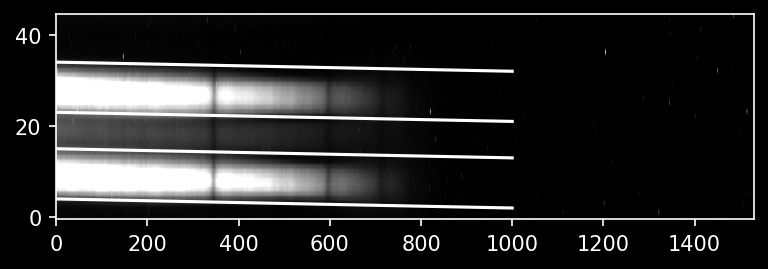

In [6]:
intertrace_cuts = np.array([4,15,23,34])
pl.imshow(alt_array[ystart:yend,:], cmap='gray', vmax=3000, vmin=0)
pl.plot([0,1000], intertrace_cuts + np.array([0,1000])[:,None] * slope, color='w')
pl.gca().set_aspect(10)

In [7]:
npixels_to_cut = 4 # very conservative - we'll see why below
xvals = np.arange(alt_array.shape[1])
trace_center = ystart+(intertrace_cuts[2] + intertrace_cuts[3])/2 + xvals * slope
cutout_trace = np.array([alt_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)]).T
cutout_trace.shape

(8, 1530)

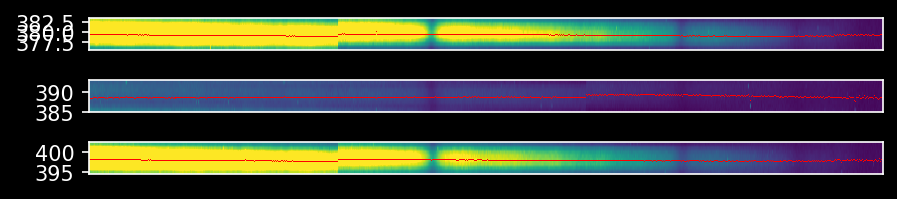

In [8]:
# to get the y-axis values corresponding to each part of our cutout trace, we do the same operation we did on the image
yaxis_full = np.arange(alt_array.shape[0])
yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                    for yval, ii in zip(trace_center, xvals)]).T
xend = 800
weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
pl.figure(figsize=(8,3))
traces = {}
for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([alt_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    
    # it takes a little mental gymnastics to get to this, but: to show the trace properly on our cutout,
    # we need to calculate the local version
    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    traces[trace_index] = weighted_yaxis_values
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut],vmax=3000, vmin=0 )
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(4)
    ax.set_xticks([])
pl.tight_layout()

(0.0, 800.0, 370.0, 415.0)

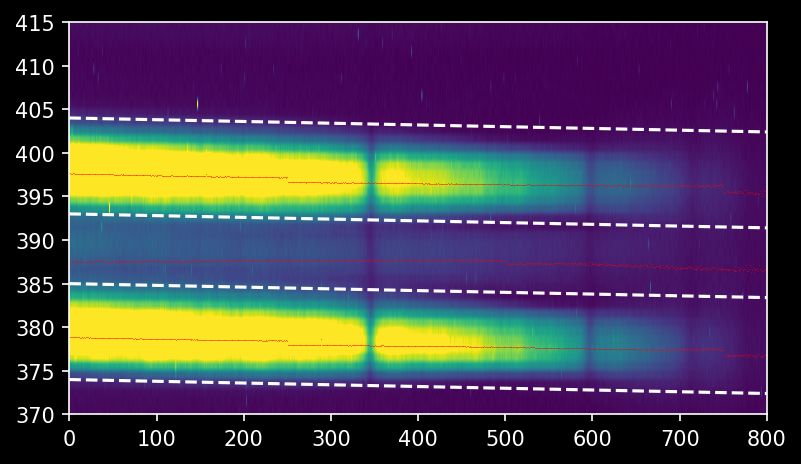

In [9]:
# then we can plot the "global" version here
pl.imshow(alt_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend], vmax=3000, vmin=0)
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for trace in traces.values():
    pl.plot(xvals[:xend], trace[:xend], 'r,', alpha=0.5)
pl.axis((0,xend,ystart,yend))

In [10]:
traces = {key: traces[key] for key in [0,2]}

(0.0, 800.0, 370.0, 415.0)

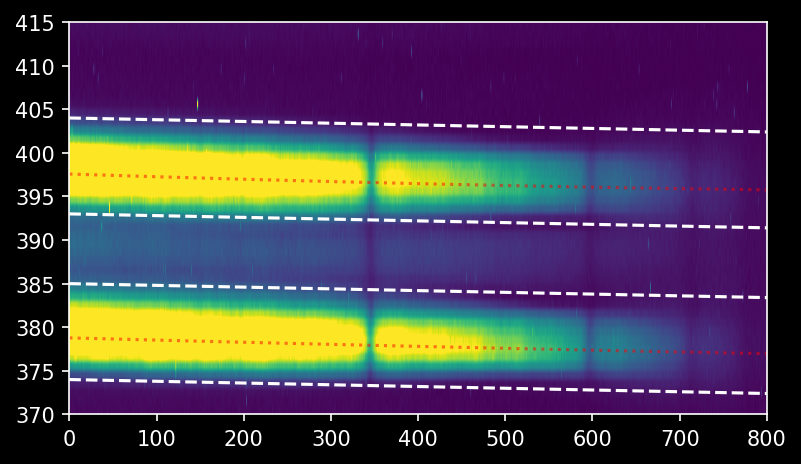

In [11]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

pl.imshow(alt_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=3000,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

(0.0, 800.0)

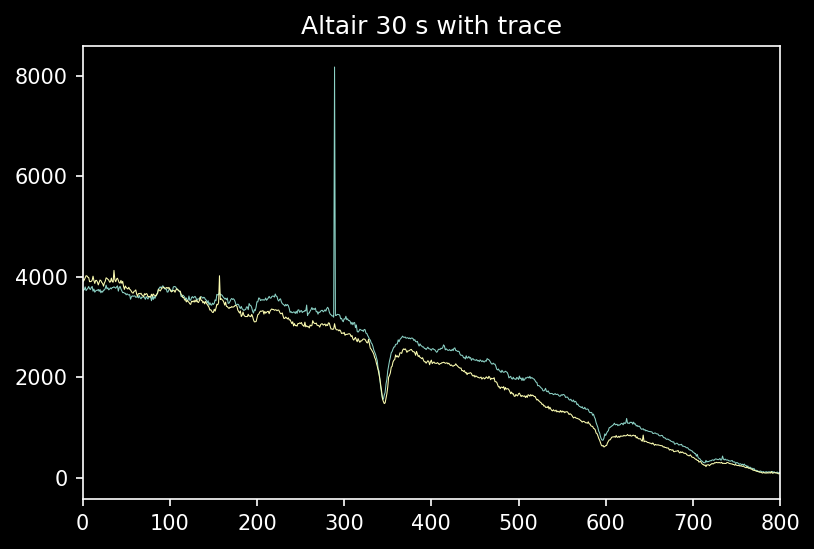

In [12]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

npixels_to_cut_trace = 4
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([alt_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            alt_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum
    
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
    pl.title("Altair 30 s with trace")
pl.xlim(0,800)

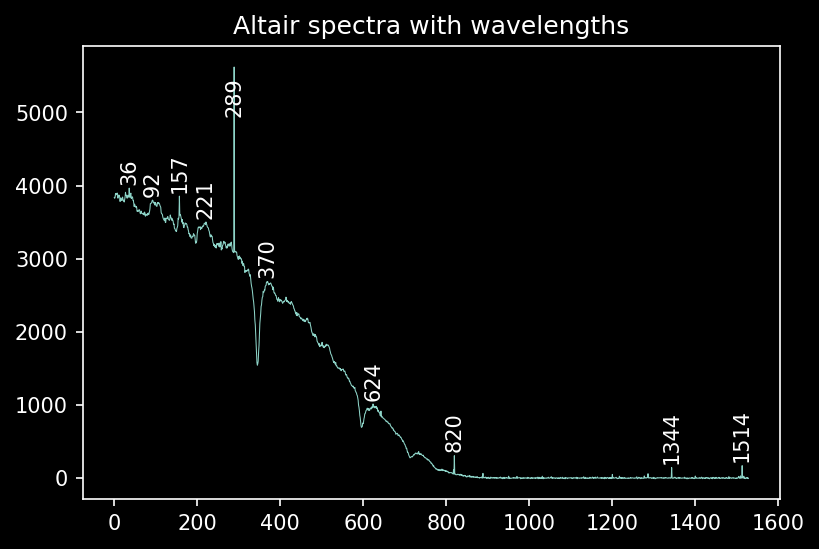

In [13]:
import scipy.signal

mean_he = np.nanmean([spectra[ind] for ind in spectra], axis = 0)
pl.plot(mean_he, linewidth = 0.5)
pl.title("Altair spectra with wavelengths")
#pl.ylim(-10,200)

peaks,_ = scipy.signal.find_peaks(mean_he, prominence = 130)

for peak in peaks:
    pl.text(peak,
           min([mean_he[peak] + 100, 5000]), peak,
           rotation = 90, horizontalalignment = 'center',)
    

In [14]:
peaks

array([  36,   92,  157,  221,  289,  370,  624,  820, 1344, 1514],
      dtype=int64)

In [15]:
## don't have darks for these so using 30 s - if hot pixles are sensitive then this might be an issue 
he_20s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\he_20s.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_30s00*.FIT")],
                        axis=0)
             )

he_array = np.array(he_20s_image_data)
he_array = he_array - np.median(he_20s_image_data)
xaxis = np.arange(he_20s_image_data.shape[1]) 

In [16]:
wlmodel = Linear1D(slope=1.00238884, intercept=-2.90420708)

In [17]:
altair_line = spectra[0]
wavelengths = wlmodel(xaxis) 
wavelengths

array([-2.90420708e+00, -1.90181824e+00, -8.99429400e-01, ...,
        1.52774355e+03,  1.52874594e+03,  1.52974833e+03])

In [18]:
altair_guess = [343,595,710]
npixels = 10
improved_altair_guess = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=altair_line[g-npixels:g+npixels] - np.median(altair_line))
                         for g in altair_guess]
improved_altair_guess

[341.9357704006864, 593.6453763109679, 707.3414156975451]

Text(0.5, 0, 'wavelength')

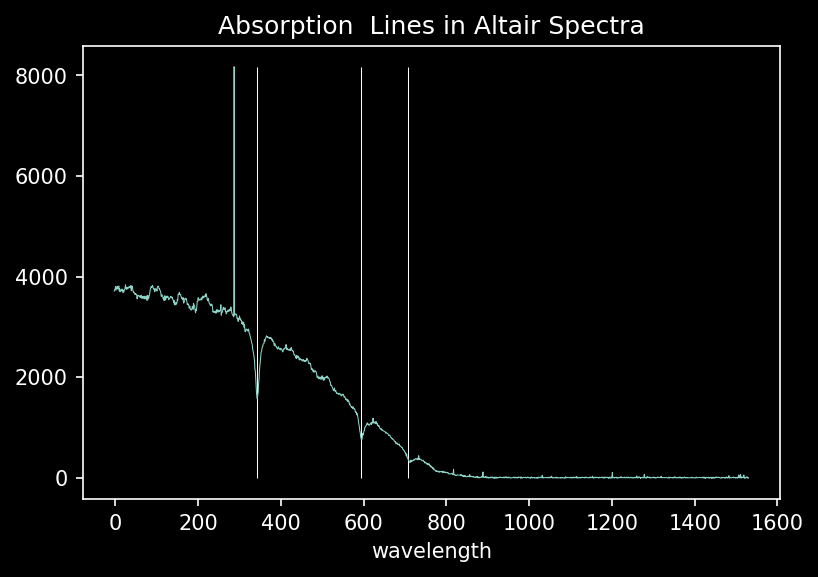

In [19]:
pl.plot(wavelengths, altair_line, linewidth = 0.5)
pl.vlines(x=improved_altair_guess, ymin=0, ymax=max(altair_line), linewidth = 0.5)
pl.title('Absorption  Lines in Altair Spectra')
pl.xlabel('wavelength')

Text(0, 0.5, 'Intensity (arbitrary units)')

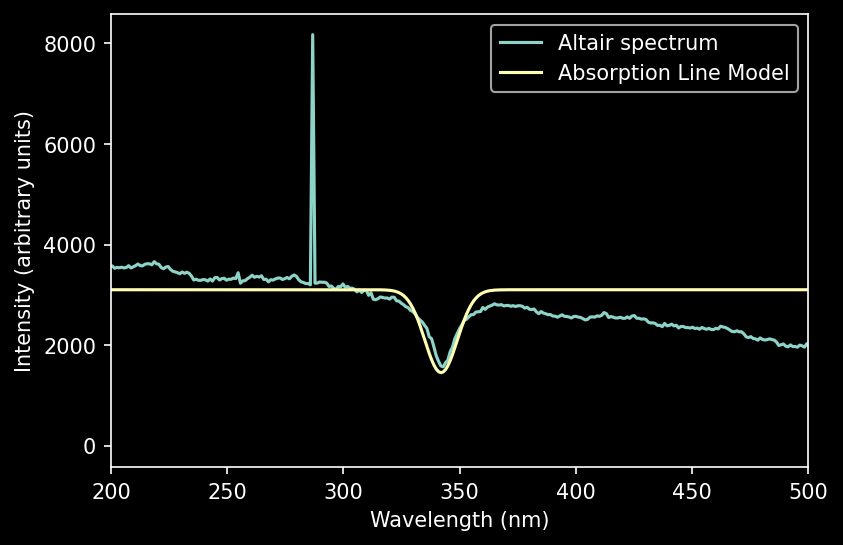

In [20]:
absorption_model_guess = (Linear1D(slope=0, intercept=3100) +
                          Gaussian1D(amplitude=-1650, mean=342, stddev=7))

pl.plot(wavelengths, altair_line, label="Altair spectrum")
pl.plot(wavelengths, absorption_model_guess(wavelengths), label='Absorption Line Model')
pl.xlim([200,500])
pl.legend(loc='best')
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

Text(0.5, 1.0, 'Altair Absorption Line Model 1 at ~ 341 nm')

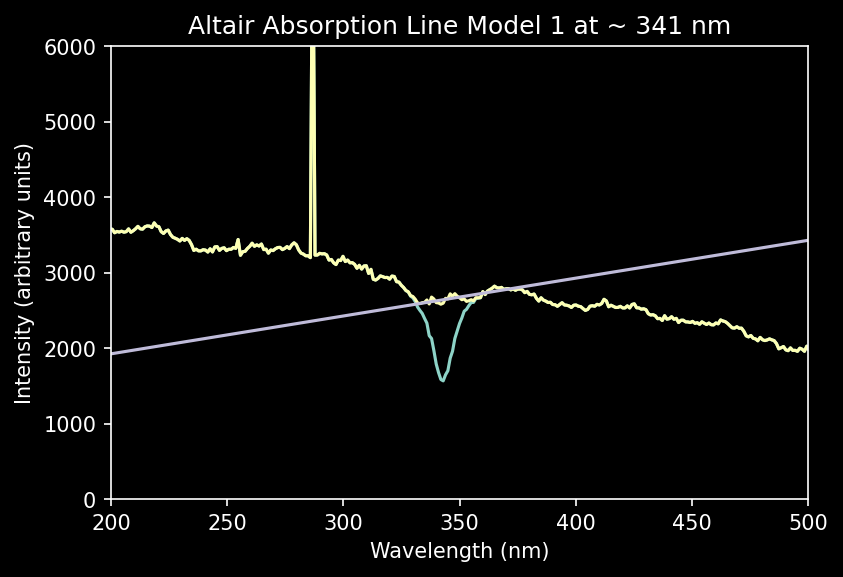

In [21]:
# fit the absorption line model to the cutout region around the line
lmfitter = LevMarLSQFitter()
selection = (wavelengths > 330) & (wavelengths < 370) 
fitted_absorption_model = lmfitter(model=absorption_model_guess,
                                   x=wavelengths[selection],
                                   y=altair_line[selection])

# split our compound model into two components
continuum_fit, absorption_fit = fitted_absorption_model
fitted_absorption_model, continuum_fit, absorption_fit

# show the spectrum before and after subtracting the line
pl.plot(wavelengths, altair_line)
pl.plot(wavelengths, altair_line - absorption_fit(wavelengths))
pl.plot(wavelengths, continuum_fit(wavelengths))
pl.xlim([200,500])
pl.ylim(0,6000)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")
pl.title("Altair Absorption Line Model 1 at ~ 341 nm")

In [22]:
EQW1 =  (-absorption_fit(wavelengths[selection]).sum() /
        continuum_fit(wavelengths[selection]).mean()) * u.nm
EQW1

<Quantity 4.42343961 nm>

In [23]:
from astropy import constants
air_wavelength_hbeta = 486.135*u.nm # wikipedia https://en.wikipedia.org/wiki/Balmer_series

In [24]:
# what's the linewidth?
linewidth_kms = (absorption_fit.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms

<Quantity 2844.75821744 km / s>

# 2nd line

Text(0, 0.5, 'Intensity (arbitrary units)')

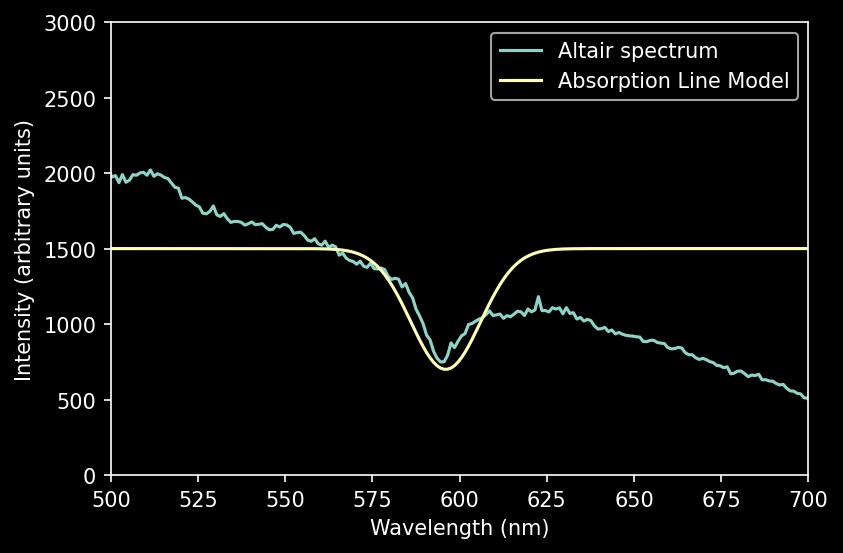

In [25]:
absorption_model_guess2 = (Linear1D(slope=0, intercept=1500) +
                          Gaussian1D(amplitude=-800, mean=596, stddev=10))

pl.plot(wavelengths, altair_line, label="Altair spectrum")
pl.plot(wavelengths, absorption_model_guess2(wavelengths), label='Absorption Line Model')
pl.xlim([500,700])
pl.ylim(0,3000)
pl.legend(loc='best')
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

Text(0.5, 1.0, 'Altair Absorption Line Model 1 at ~ 594 nm')

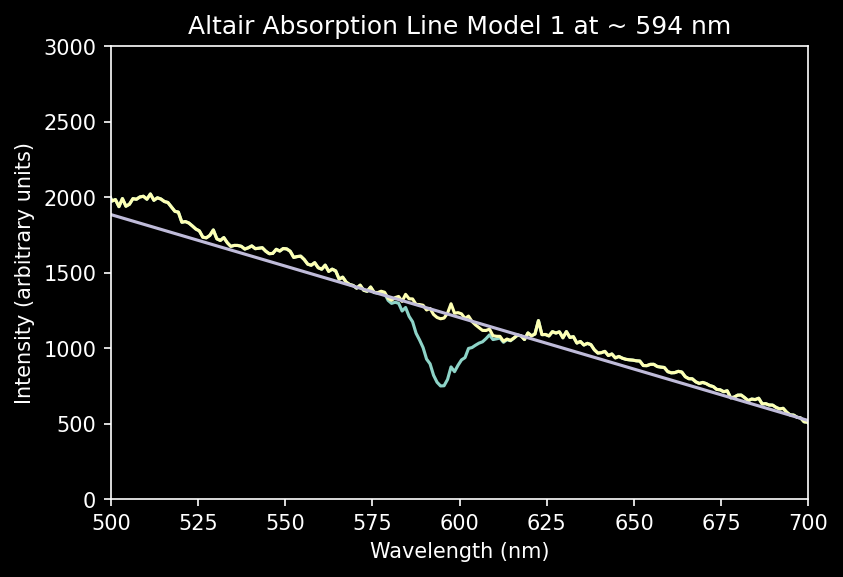

In [26]:
# fit the absorption line model to the cutout region around the line
lmfitter = LevMarLSQFitter()
selection2 = (wavelengths > 575) & (wavelengths < 625) 
fitted_absorption_model2 = lmfitter(model=absorption_model_guess2,
                                   x=wavelengths[selection2],
                                   y=altair_line[selection2])

# split our compound model into two components
continuum_fit2, absorption_fit2 = fitted_absorption_model2
fitted_absorption_model2, continuum_fit2, absorption_fit2

# show the spectrum before and after subtracting the line
pl.plot(wavelengths, altair_line)
pl.plot(wavelengths, altair_line - absorption_fit2(wavelengths))
pl.plot(wavelengths, continuum_fit2(wavelengths))
pl.xlim([500,700])
pl.ylim(0,3000)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")
pl.title("Altair Absorption Line Model 1 at ~ 594 nm")

In [27]:
EQW2 =  (-absorption_fit2(wavelengths[selection2]).sum() /
        continuum_fit2(wavelengths[selection2]).mean()) * u.nm
EQW2

<Quantity 5.56435972 nm>

In [28]:
linewidth_kms2 = (absorption_fit2.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms2

<Quantity 3677.81263542 km / s>

# 3rd line

Text(0, 0.5, 'Intensity (arbitrary units)')

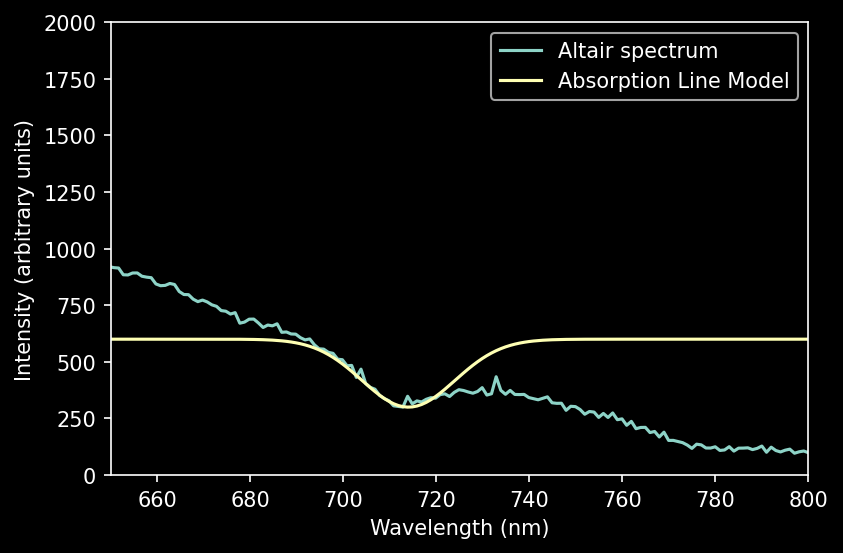

In [29]:
absorption_model_guess3 = (Linear1D(slope=0, intercept=600) +
                          Gaussian1D(amplitude=-300, mean=714, stddev=10))

pl.plot(wavelengths, altair_line, label="Altair spectrum")
pl.plot(wavelengths, absorption_model_guess3(wavelengths), label='Absorption Line Model')
pl.xlim([650,800])
pl.ylim(0,2000)
pl.legend(loc='best')
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

Text(0.5, 1.0, 'Altair Absorption Line Model 1 at ~ 707 nm')

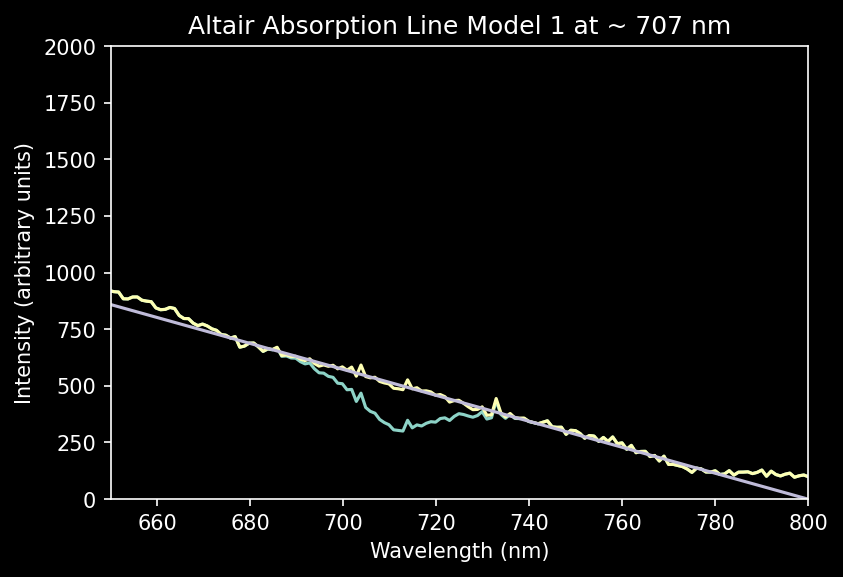

In [30]:
# fit the absorption line model to the cutout region around the line
lmfitter = LevMarLSQFitter()
selection3 = (wavelengths > 670) & (wavelengths < 740) 
fitted_absorption_model3 = lmfitter(model=absorption_model_guess3,
                                   x=wavelengths[selection3],
                                   y=altair_line[selection3])

# split our compound model into two components
continuum_fit3, absorption_fit3 = fitted_absorption_model3
fitted_absorption_model3, continuum_fit3, absorption_fit3

# show the spectrum before and after subtracting the line
pl.plot(wavelengths, altair_line)
pl.plot(wavelengths, altair_line - absorption_fit3(wavelengths))
pl.plot(wavelengths, continuum_fit3(wavelengths))
pl.xlim([650,800])
pl.ylim(0,2000)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")
pl.title("Altair Absorption Line Model 1 at ~ 707 nm")

In [32]:
EQW3 =  (-absorption_fit3(wavelengths[selection3]).sum() /
        continuum_fit3(wavelengths[selection3]).mean()) * u.nm
EQW3

<Quantity 7.46173749 nm>

In [33]:
linewidth_kms3 = (absorption_fit3.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms3

<Quantity 5415.72951564 km / s>